Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import Encoder_Decoder_Model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Load Data

In [2]:
# diff_grid = np.load('dataset/diff_grid.npz')['arr_0'] # Non-compressed 7100x7100 diff grid
diff_grid = np.load('../dataset/compressed_diff_grid.npz')['arr_0'] # Compressed 1775x1775 diff grid
label = np.load('../dataset/norm_diffraction_label.npz')['arr_0']

diff = torch.tensor(diff_grid,device=device).float()
phase = torch.tensor(label[:, 0],device=device).float()
amp = torch.tensor(label[:, 1],device=device).float()

Train Model

In [3]:
# Testing Different Loss functions

# from torchmetrics import PeakSignalNoiseRatio
# from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
lossfn =  nn.L1Loss()
#lossfn =  nn.MSELoss()
#lossfn = PeakSignalNoiseRatio(data_range=1.0).to(device)
#lossfn =  MultiScaleStructuralSimilarityIndexMeasure().to(device) # must be positive number
#lossfn =  nn.BCELoss(reduction='mean')

def ModelLoss(pred1, target1, pred2, target2):
  loss1 = lossfn(pred1, target1)
  loss2 = lossfn(pred2, target2)
  return loss1, loss2

In [4]:
def train_model(model, input, target1, target2, optimizer, criterion, scheduler=None):
  model.train()
  phase_pred, amp_pred = model(input)
  loss1, loss2 = criterion(phase_pred, target1, amp_pred, target2)
  loss = loss1 + loss2

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if(scheduler != None):
    scheduler.step()
  return loss1, loss2, loss

In [7]:
def hyperparameter(num_epochs, learning_rate):
  plt.subplot(2, 1, 2, facecolor='white')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


  PtychoModel = Encoder_Decoder_Model.Model().to(device)
  torch.save(PtychoModel.state_dict(), 'initial.pth')
  criterion = ModelLoss
  
  for l_rate in learning_rate:
    PtychoModel.load_state_dict(torch.load('initial.pth'))
    optimizer = torch.optim.AdamW(PtychoModel.parameters(), lr=l_rate, betas=(0.59418, 0.8699))
    loss_hist = []
    for epoch in range(num_epochs):
      loss1, loss2, loss = train_model(PtychoModel, diff, phase, amp, optimizer, criterion)

      if((epoch+1) % 200 == 0):
        print("Epoch: ", (epoch+1), " Training Loss: ", round(loss.item(), 5), " L1: ",round(loss1.item(), 7)," L2: ", round(loss2.item(), 7))
      if((epoch+1) % 50 == 0):
        loss_hist.append(loss.item())
    plt.plot(loss_hist, '-', label= 'trn_acc:'+str(l_rate))
  plt.legend(loc='upper right')
  plt.gcf().set_size_inches(15, 15)
  plt.show()

Epoch:  200  Training Loss:  0.15468  L1:  0.1242646  L2:  0.0304124
Epoch:  400  Training Loss:  0.15431  L1:  0.1240264  L2:  0.030283
Epoch:  600  Training Loss:  0.15433  L1:  0.1240826  L2:  0.0302477
Epoch:  800  Training Loss:  0.15402  L1:  0.1237986  L2:  0.0302253
Epoch:  1000  Training Loss:  0.15387  L1:  0.1236604  L2:  0.0302115
Epoch:  1200  Training Loss:  0.15375  L1:  0.1235432  L2:  0.0302034
Epoch:  1400  Training Loss:  0.15372  L1:  0.1235253  L2:  0.0301937
Epoch:  1600  Training Loss:  0.15363  L1:  0.1234452  L2:  0.0301822
Epoch:  1800  Training Loss:  0.15371  L1:  0.1235352  L2:  0.0301769
Epoch:  2000  Training Loss:  0.15354  L1:  0.1233696  L2:  0.0301749
Epoch:  2200  Training Loss:  0.15359  L1:  0.1234305  L2:  0.0301597
Epoch:  2400  Training Loss:  0.15351  L1:  0.1233343  L2:  0.0301747
Epoch:  2600  Training Loss:  0.15344  L1:  0.1232855  L2:  0.0301499
Epoch:  2800  Training Loss:  0.1534  L1:  0.1232591  L2:  0.0301428
Epoch:  3000  Training Los

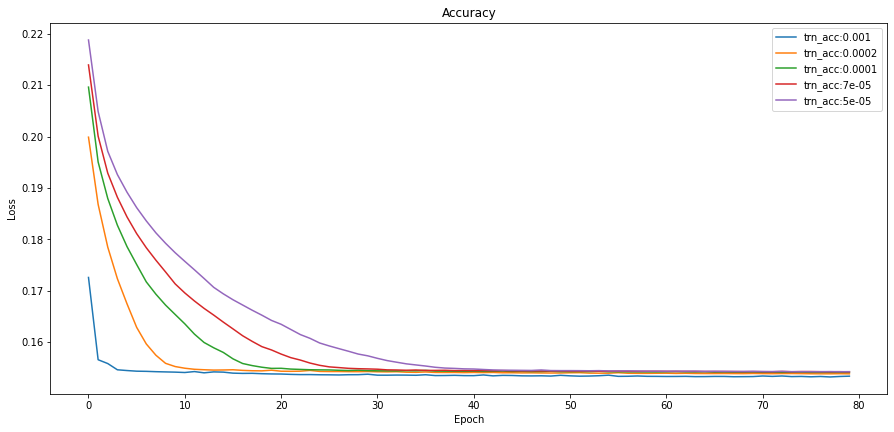

In [8]:
epochs = 4000
lr = [0.0010, 0.0002, 0.0001, 0.00007, 0.00005]
hyperparameter(epochs, lr)

Train Using Best Hyperparameter

In [ ]:
def train(model, lr, num_epochs, step_size=5000):
  plt.subplot(2, 1, 2, facecolor='white')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  loss_hist = []
  rec_freq = num_epochs//100
  
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.6, 0.99))
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr/10, max_lr=lr, step_size_up=step_size, cycle_momentum=False, mode='triangular2')
  criterion = ModelLoss

  for epoch in range(num_epochs):
    loss1, loss2, loss = train_model(model, diff, phase, amp, optimizer, criterion, scheduler)
    if((epoch+1) % 200 == 0):
      print("Epoch: ", (epoch+1), " Training Loss: ", round(loss.item(), 5), " L1: ",round(loss1.item(), 7)," L2: ", round(loss2.item(), 7))
    if((epoch+1) % rec_freq == 0):
        loss_hist.append(loss.item())
  plt.plot(loss_hist, '-', label= 'trn_acc:'+str(lr))
  plt.legend(loc='upper right')
  plt.gcf().set_size_inches(15, 15)
  plt.show()
  
  torch.save(model.state_dict(), '../models/L1_20000_lr001.pth')

In [ ]:
PtychoModel = Encoder_Decoder_Model.Model().to(device)
PtychoModel.load_state_dict(torch.load('../models/L1_10000_lr001.pth'))
train(PtychoModel, 0.001, 1000)

Results

In [17]:
def visualize(model):
  model.eval()
  phase_pred, amp_pred = model(diff)
  
  f, ax = plt.subplots(4,4, figsize=(12, 12), facecolor='white')
  ax[0,0].set_ylabel('PtychoNeuralNetwork', fontsize = 12.0)
  ax[1,0].set_ylabel('E-Pie (300 Iterations)', fontsize = 12.0)
  ax[2,0].set_ylabel('PtychoNeuralNetwork', fontsize = 12.0)
  ax[3,0].set_ylabel('E-Pie (300 Iterations)', fontsize = 12.0)

  ax[0,0].imshow(phase_pred[0].cpu().detach().numpy().reshape((650,650)))
  ax[0,1].imshow(phase_pred[1].cpu().detach().numpy().reshape((650,650)))
  ax[0,2].imshow(phase_pred[2].cpu().detach().numpy().reshape((650,650)))
  ax[0,3].imshow(phase_pred[3].cpu().detach().numpy().reshape((650,650)))
  ax[1,0].imshow(phase[0].cpu().detach().numpy().reshape((650,650)))
  ax[1,1].imshow(phase[1].cpu().detach().numpy().reshape((650,650)))
  ax[1,2].imshow(phase[2].cpu().detach().numpy().reshape((650,650)))
  ax[1,3].imshow(phase[3].cpu().detach().numpy().reshape((650,650)))
  ax[2,0].imshow(amp_pred[0].cpu().detach().numpy().reshape((650,650)))
  ax[2,1].imshow(amp_pred[1].cpu().detach().numpy().reshape((650,650)))
  ax[2,2].imshow(amp_pred[2].cpu().detach().numpy().reshape((650,650)))
  ax[2,3].imshow(amp_pred[3].cpu().detach().numpy().reshape((650,650)))
  ax[3,0].imshow(amp[0].cpu().detach().numpy().reshape((650,650)))
  ax[3,1].imshow(amp[1].cpu().detach().numpy().reshape((650,650)))
  ax[3,2].imshow(amp[2].cpu().detach().numpy().reshape((650,650)))
  ax[3,3].imshow(amp[3].cpu().detach().numpy().reshape((650,650)))


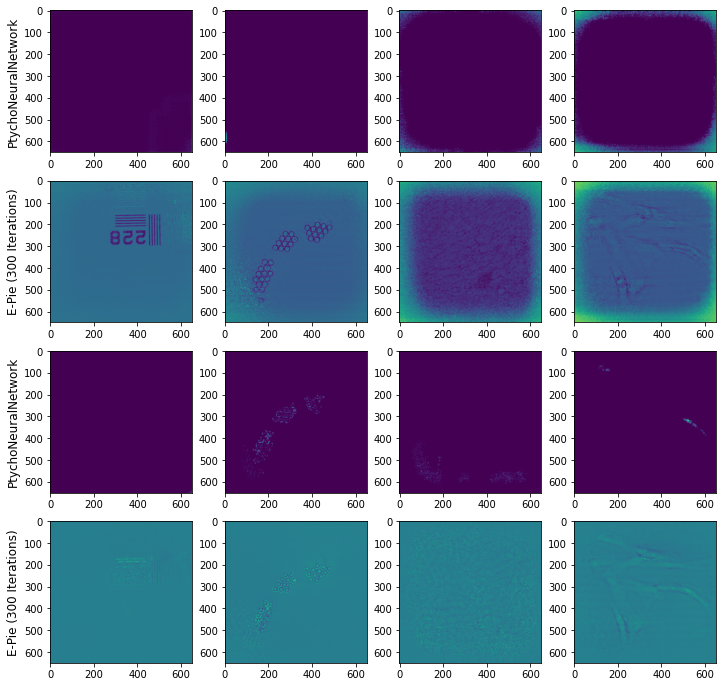

In [23]:
PtychoModel = Encoder_Decoder_Model.Model().to(device)
PtychoModel.load_state_dict(torch.load('../models/L1_20000_lr001.pth'))
visualize(PtychoModel)